In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_filling_1_t_4_em4_random_basis_mesh_60_gpu_scaling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
v1_arr = u_arr
u_mesh, v1_mesh = np.meshgrid(u_arr, v1_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(1.566654659257427e-05)

In [4]:
np.max(final_e_difference)

np.float64(9.977559223273147e-09)

In [5]:
np.all(any_bi_fail)==False

np.True_

### Phase Analysis

In [6]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)

In [7]:
from functions_parameters.universal_parameters import phase_1_1, threshold, c_6_uc, c_3_uc, c_2_uc
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros(u_mesh.shape)
nematic_measure = np.zeros(u_mesh.shape)
f_phase = np.zeros(u_mesh.shape)
f_measure = np.zeros(u_mesh.shape)
f_max_measure = np.zeros(u_mesh.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        d_o = sorted_density[i,j,0]
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
        phase_arr = np.kron(rs_recording,m_recording)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j]=phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_1_1[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(u_mesh.shape[0]):
    for j in range(u_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

Text(0.5, 1.0, 'filling = 1')

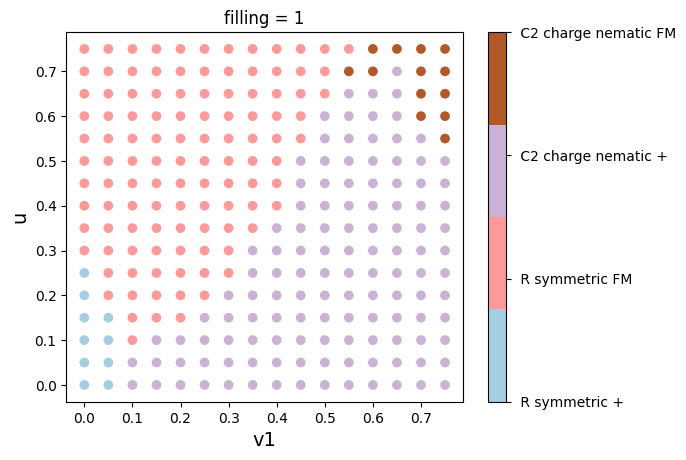

In [8]:
colorbar_ticks_combined = np.arange(len(unique_phase_index))
cmap = plt.get_cmap("Paired", len(unique_phase_index))
# plt.pcolormesh(e_fermi_mesh, u_mesh, phase_diagram_combined_op.T, cmap="Paired")
plt.scatter(v1_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)
plt.title('filling = 1')

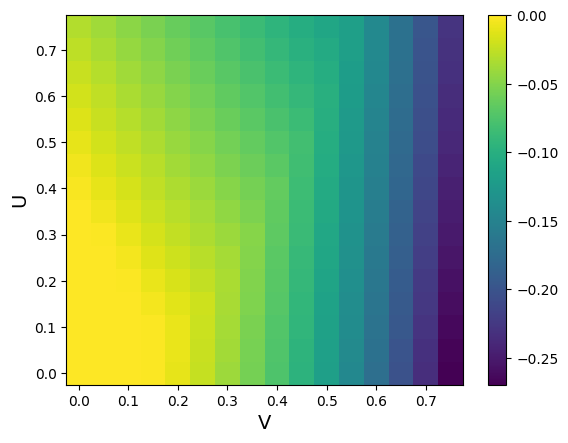

In [9]:
plt.pcolormesh(v1_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

In [10]:
from functions_parameters.jax_schf_helpers import *
from functions_parameters.bond_table_generator import build_buckets_per_shell

basis_frac = np.array([[1/2, 0], [1/2, 1/2], [0, 1/2]])
norb = basis_frac.shape[0]
num_k_mesh = 60
b_0 = np.linspace(-b[0] / 2, b[0] / 2, num_k_mesh, endpoint=False)
b_1 = np.linspace(-b[1] / 2, b[1] / 2, num_k_mesh, endpoint=False)
k_mesh_points = np.vstack([v1 + v2 for v1, v2 in product(b_0, b_1)])
num_k_points = k_mesh_points.shape[0]

radii, a_lists, deltas = build_buckets_per_shell(a, basis_frac, 2)

# in this case, as both TB model and interaction, we include up to NNN, the a_list and deltas are the same
# calculate the correlation matrix
temperature = 4E-4
filling = 1/2
mu = 2
t_nn = 1
t_nnn = -0.025
t_arr = np.array([t_nn, t_nnn])

phase_pos, phase_neg = precompute_k_phase_tables(deltas, a, k_mesh_points)
Htb, e_all, v_all, v_all_dagger = hk_all_k_from_phases(mu, a_lists, t_arr, phase_neg)

nk = e_all.shape[0]
norb = e_all.shape[1]
e_fermi_iterated, ne, converged, iters = fermi_level_bisection_core(e_all, filling, temperature)
electron_count = occ(e_all, e_fermi_iterated, temperature)
# (U @ diag(electron_count) @ U_d).T
corr_k = jnp.einsum('Nni,Ni,Nim->Nmn', v_all, electron_count, v_all_dagger)
# count the spin degeneracy
gs_e = jnp.einsum('Nji, Nji->', Htb, corr_k)/nk*2

# then obtain the mean field decomposition and corresponding 
bond_ref = bond_orders_from_phases(a_lists, corr_k, phase_neg)
bond_ref = np.stack((bond_ref, bond_ref), axis=1)

bond_difference = final_bond[:,:,0] - bond_ref[np.newaxis,np.newaxis,:]

In [11]:
bond_difference.shape

(16, 16, 9, 2, 2, 3, 3)

In [12]:
bond_difference_ij = np.sqrt(np.sum(np.abs(bond_difference), axis=(2,3,4,5,6)))

Text(0.5, 1.0, 'ground state max magnetization')

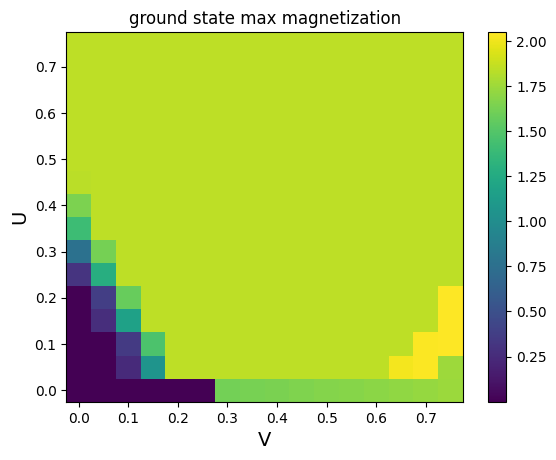

In [13]:
plt.pcolormesh(v1_mesh,u_mesh,bond_difference_ij)
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()
plt.title('ground state max magnetization')

## Select states for next run

In [14]:
selected_indexes = [(4,-1,0), (5,-5,0), (-5,-3,0), (-5,-2,0), (0,-1,0), (-2,-3,0), (-1,0,0), (-1,-6,0)]

In [15]:
# first find if there are energy states that are highly degenerate as the known ground state while in the different phase
states_index = np.where(np.logical_and(sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]<1E-4, sorted_ground_state_e - sorted_ground_state_e[:,:,0][:,:,np.newaxis]>1E-7))
# then find out the states that are in a different phase than the known ground state
states_index_len = len(states_index[0])
degenerate_state_diagram = -np.ones(final_c_difference.shape, dtype=np.int32)
for index in range(states_index_len):
    i = states_index[0][index]
    j = states_index[1][index]
    k = states_index[2][index]
    d_ij = sorted_density[i,j,k]
    rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_o, c_6_uc, c_3_uc, c_2_uc)
    phase_arr = np.kron(rs_recording,m_recording)
    phase = np.argmax(phase_arr)
    if phase != phase_diagram_based_on_d[i,j] and phase not in degenerate_state_diagram[i,j]:
        degenerate_state_diagram[i,j,k]=phase
    


In [16]:
degenerate_index = np.where(degenerate_state_diagram>0)

In [17]:
degenerate_index

(array([ 0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,
         8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
        12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 15, 15]),
 array([ 2,  9,  2,  9, 10,  2, 10, 11,  1,  5, 10, 11,  1,  5, 10, 14, 15,
         0,  5,  6, 10, 11, 14,  0,  5,  6, 10, 12,  5,  6, 10, 12, 13,  5,
         6, 10, 11, 12, 13,  5,  6,  5,  6, 11, 13, 15,  5,  6, 11, 12, 14,
         5,  6, 11, 13,  5,  6, 11, 12, 13,  5,  6,  5,  6]),
 array([6, 2, 6, 2, 6, 4, 7, 4, 7, 6, 7, 4, 7, 3, 2, 1, 1, 7, 3, 3, 2, 2,
        7, 3, 5, 3, 4, 5, 5, 3, 4, 5, 7, 6, 5, 1, 2, 4, 2, 6, 5, 6, 5, 4,
        1, 6, 6, 6, 2, 4, 6, 6, 6, 2, 2, 6, 6, 2, 1, 4, 6, 6, 6, 6]))

In [19]:
selected_indexes.append((4,-1,0))

In [20]:
selected_d = np.zeros((len(selected_indexes),2,norb), dtype=np.complex128)
selected_bond = np.zeros((len(selected_indexes),)+sorted_bond[0,0,0].shape, dtype=np.complex128)
count = 0
for index in selected_indexes:
    i = index[0]
    j = index[1]
    k = index[2]
    selected_d[count] = sorted_density[i,j,k]
    selected_bond[count] = sorted_bond[i,j,k]
    count += 1

In [21]:
selected_d.shape

(9, 2, 3)

In [22]:
selected_indexes

[(4, -1, 0),
 (5, -5, 0),
 (-5, -3, 0),
 (-5, -2, 0),
 (0, -1, 0),
 (-2, -3, 0),
 (-1, 0, 0),
 (-1, -6, 0),
 (4, -1, 0)]

In [23]:
i,j,k

(4, -1, 0)

In [24]:
import os

In [25]:
np.savez_compressed("filling_1_rerun_basis_v1_V2.npz",
    d = selected_d,
    bond = selected_bond,
)

In [26]:
np.mean(final_iteration)

np.float64(79.762890625)

In [27]:
np.max(final_iteration)

np.int32(500)

In [28]:
np.min(final_iteration)

np.int32(2)

# Obtain a better phase diagram

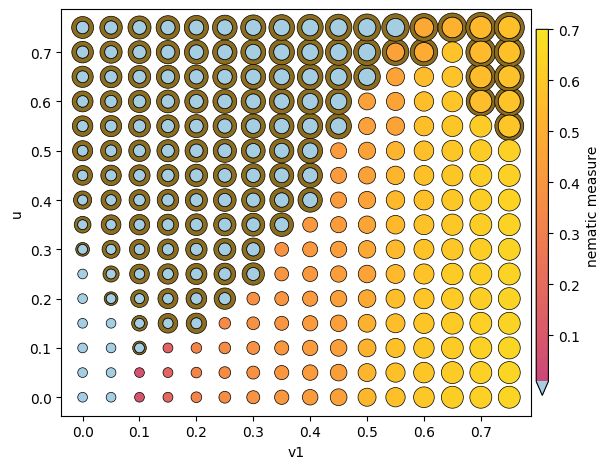

In [31]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

ts_check = np.zeros(u_mesh.shape)
CFG = PlotConfig(nem_vmax=0.7)
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    v1_mesh, u_mesh,
    sorted_ground_state_e,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()

In [30]:
np.max(nematic_measure)

np.float64(0.6476659717052996)